In [6]:
from importlib import reload
from matplotlib.axes import Axes
from script import packetPreprocessing, packetsHandler,testAndVerification
import decimal
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series
import math
import random
import gc


from script.packetPreprocessing import *
from script.packetsHandler import *
import time
from script.testAndVerification import plot_diff_timescales, tsplot
reload(packetsHandler)
reload(packetPreprocessing)

ModuleNotFoundError: No module named 'script'

In [3]:

wirelens=getwirelen(readPcap('../dataset/equinix-nyc.dirA.20180315-130000.UTC.anon.pcap/'
                             'equinix-nyc.dirA.20180315-130000.UTC.anon.pcap'))

timestamps=readTimestamp("../dataset/equinix-nyc.dirA.20180315-130000.UTC.anon.times/"
                         "equinix-nyc.dirA.20180315-130000.UTC.anon.times")

timestampsAndWirelens=list(zip(timestamps,wirelens))


In [12]:
packNums0p01,timestamps0p01,byteSlots0p01, byteRates0p01=splitToTimeSlot(timestampsAndWirelens, 0.01)
packNums0p1,timestamps0p1,byteSlots0p1, byteRates0p1=splitToTimeSlot(timestampsAndWirelens, 0.1)
packNums1,timestamps1,byteSlots1, byteRates1=splitToTimeSlot(timestampsAndWirelens, 1)
packNums10,timestamps10,byteSlots10, byteRates10=splitToTimeSlot(timestampsAndWirelens, 10)




In [3]:

pd.DataFrame({
    'timestamp':timestamps0p01,
    'byterate':byteRates0p01,
    "packnum":  packNums0p01              
    }).to_csv("../dataset/data_for_0p01s_time_slot.csv",index=False)


pd.DataFrame(data={
    'timestamp':timestamps0p1,
    'byterate':byteRates0p1,
    "packnum":  packNums0p1              
       }).to_csv("../dataset/data_for_0p1s_time_slot.csv",index=False)

pd.DataFrame(data={
    'timestamp':timestamps1,
    'byterate':byteRates1,
    "packnum":  packNums1              
    }).to_csv("../dataset/data_for_1s_time_slot.csv",index=False)

pd.DataFrame(data={
    'timestamp':timestamps10,
    'byterate':byteRates10,
    "packnum":  packNums10              
    }).to_csv("../dataset/data_for_10s_time_slot.csv",index=False)



NameError: name 'pd' is not defined

In [1]:
data_prefix='../dataset/'
data001 = pd.read_csv(data_prefix+"data_for_0p01s_time_slot.csv",index_col=0)
data01 = pd.read_csv(data_prefix+"data_for_0p1s_time_slot.csv",index_col=0)
data1 = pd.read_csv(data_prefix+"data_for_1s_time_slot.csv",index_col=0)                    
data10 = pd.read_csv(data_prefix+"data_for_10s_time_slot.csv",index_col=0)  




NameError: name 'pd' is not defined

76

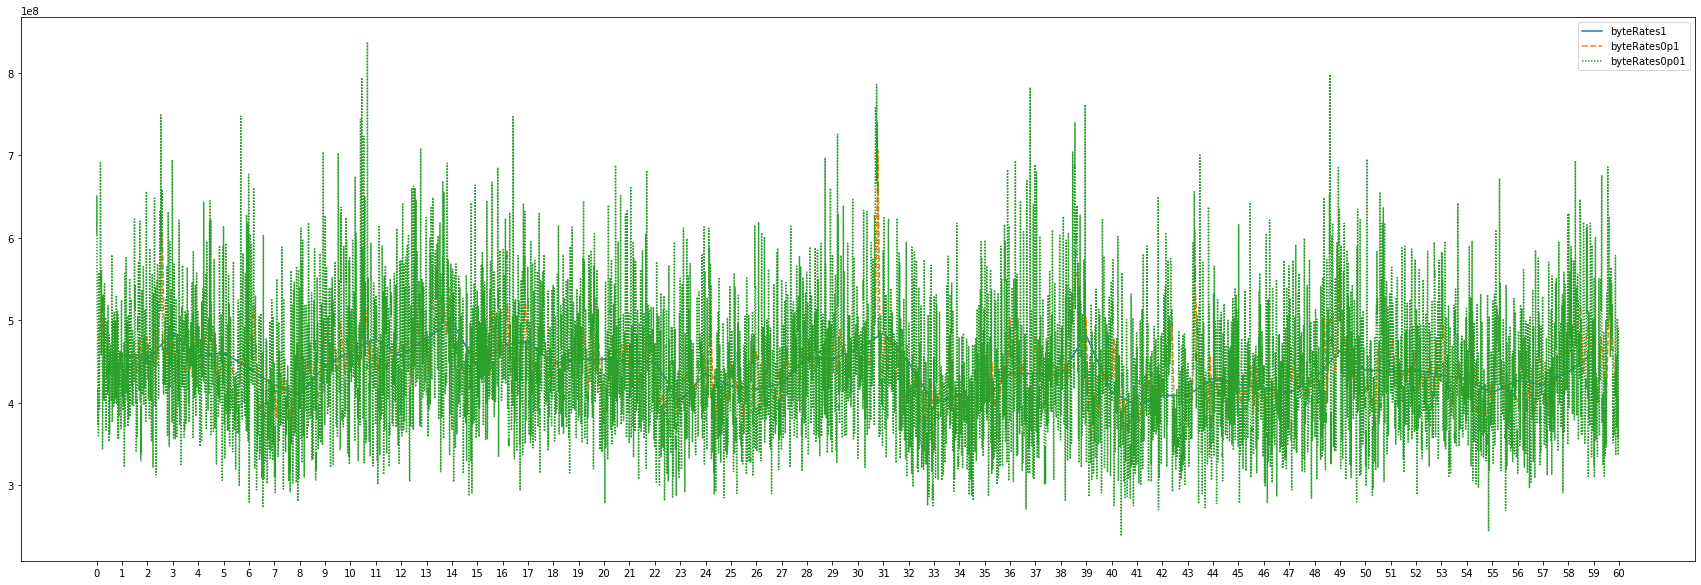

In [5]:
'''
10s
1s
0.1s
0.0.1s

'''
axes=sns.lineplot(data=[data1["byteRates1"],data01["byteRates0p1"],data001["byteRates0p01"]] )

axes.set_xticks(np.arange(data001.index[0],data001.index[-1]+1,1))
axes.set_xticklabels(np.arange(0,60+1,1))
figure=axes.get_figure()
figure.set_size_inches(30,10)
figure.savefig("../graph/byterate_for_0_001s_time_slot")
del axes,figure
gc.collect()


(<matplotlib.axes._subplots.AxesSubplot at 0x2759df90320>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2759e086240>)

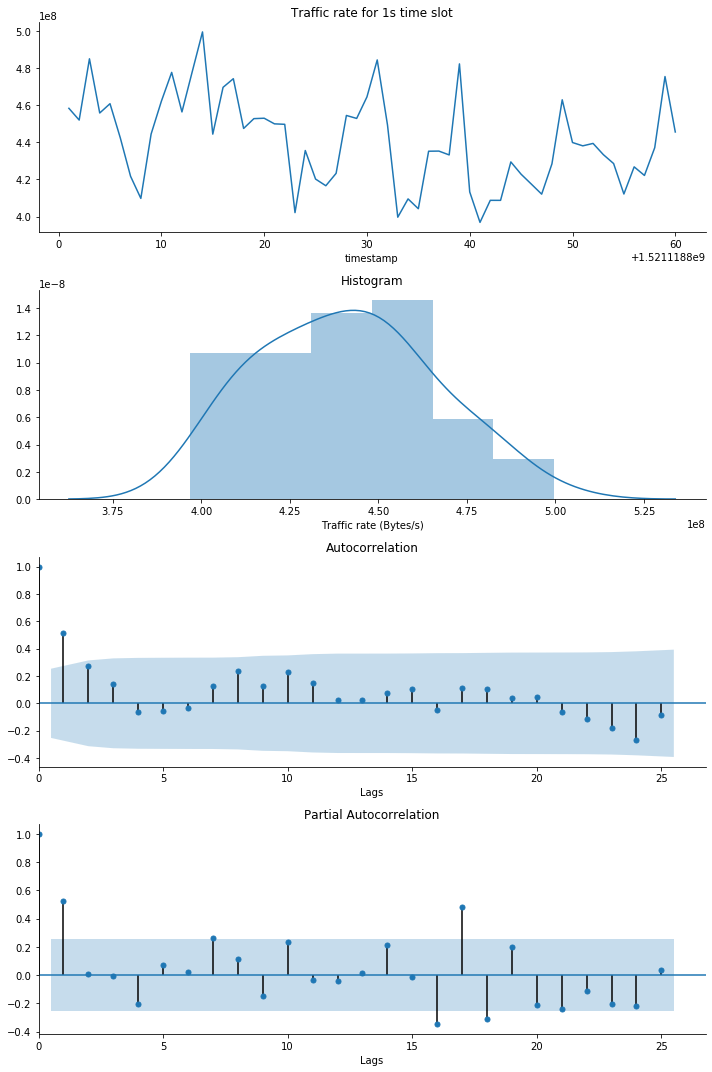

In [34]:
reload(testAndVerification)
tsplot(data1["byterate"], lags=25,title="Traffic rate for 1s time slot")

    

In [ ]:

plot_diff_timescales(data10["byterate"],
                     data1["byterate"],
                     data01["byterate"],
                     data001["byterate"],
                    )




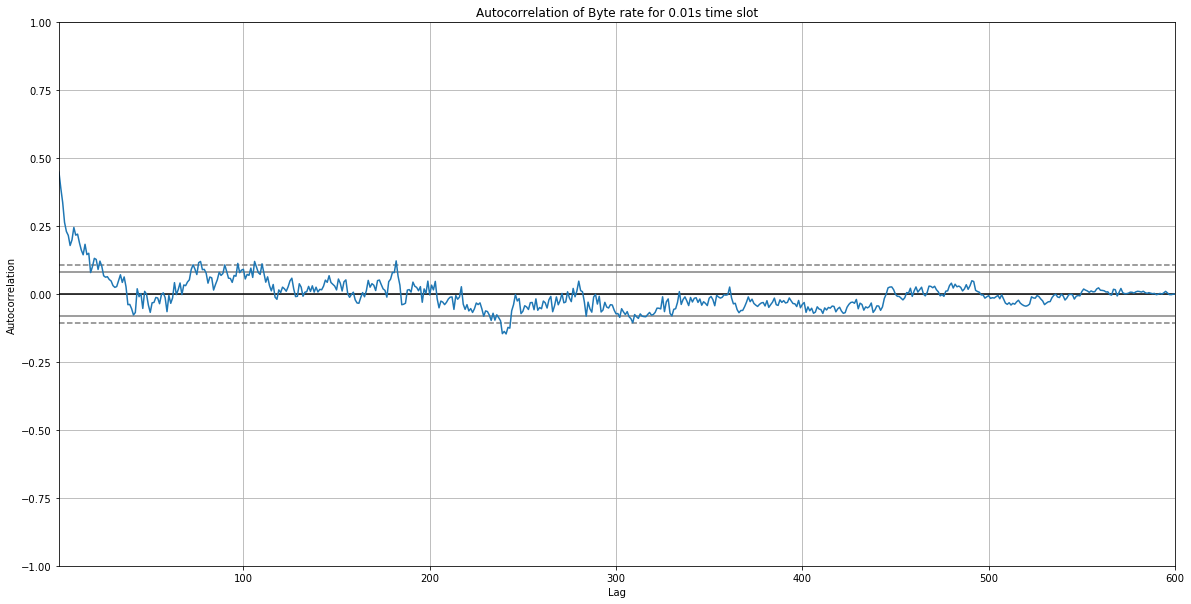

In [18]:
autofig=pd.plotting.autocorrelation_plot(list(map(int,data01["byteRates0p1"])))
autofig.set_title("Autocorrelation of Byte rate for 0.01s time slot")
autofig.get_figure().set_size_inches(20,10)
autofig.get_figure().savefig("autocorrelation_plot_0p1s")

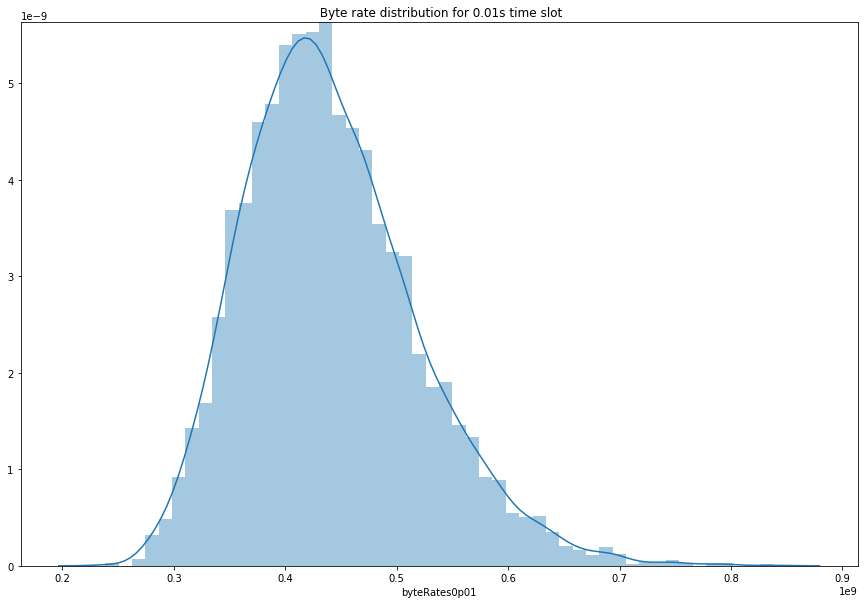

In [6]:
distfig=sns.distplot(data001["byteRates0p01"])
distfig.set_title(" Byte rate distribution for 0.01s time slot")
distfig.get_figure().set_size_inches(15,10)
distfig.get_figure().savefig("dist_plot_0p01s_time_slot")

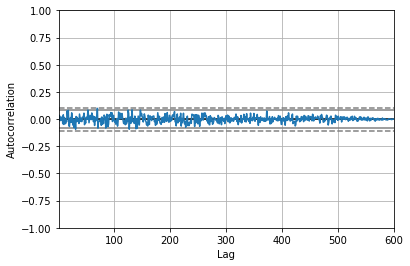

In [10]:


pd.plotting.autocorrelation_plot([random.random() for x in range(600) ])

In [ ]:
"""
Python code for fractional differencing of pandas time series
illustrating the concepts of the article "Preserving Memory in Stationary Time Series" 
by Simon Kuttruf

While this code is dedicated to the public domain for use without permission, the author disclaims any liability in connection with the use of this code.
"""



def getWeights(d,lags):
    # return the weights from the series expansion of the differencing operator
    # for real orders d and up to lags coefficients
    w=[1]
    for k in range(1,lags):
        w.append(-w[-1]*((d-k+1))/k)
    w=np.array(w).reshape(-1,1) 
    return w

def plotWeights(dRange, lags, numberPlots):
    weights=pd.DataFrame(np.zeros((lags, numberPlots)))
    interval=np.linspace(dRange[0],dRange[1],numberPlots)
    for i, diff_order in enumerate(interval):
        weights[i]=getWeights(diff_order,lags)
    weights.columns = [round(x,2) for x in interval]
    fig=weights.plot()
    plt.legend(title='Order of differencing')
    plt.title('Lag coefficients for various orders of differencing')
    plt.xlabel('lag coefficients')
    #plt.grid(False)
    plt.show()

plotWeights([0,1],7,6)

def ts_differencing(series, order, lag_cutoff):
    # return the time series resulting from (fractional) differencing
    # for real orders order up to lag_cutoff coefficients
    
    weights=getWeights(order, lag_cutoff)
    res=0
    for k in range(lag_cutoff):
        res += weights[k]*series.shift(k).fillna(0)
    return res[lag_cutoff:] 


def plotMemoryVsCorr(result, seriesName):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()  
    color1='xkcd:deep red'; color2='xkcd:cornflower blue'
    ax.plot(result.order,result['adf'],color=color1)
    ax.plot(result.order, result['5%'], color='xkcd:slate')
    ax2.plot(result.order,result['corr'], color=color2)
    ax.set_xlabel('order of differencing')
    ax.set_ylabel('adf', color=color1);ax.tick_params(axis='y', labelcolor=color1)
    ax2.set_ylabel('corr', color=color2); ax2.tick_params(axis='y', labelcolor=color2)
    plt.title('ADF test statistics and correlation for %s' % (seriesName))
    plt.show()


from statsmodels.tsa.stattools import adfuller 
def MemoryVsCorr(series, dRange, numberPlots, lag_cutoff, seriesName):
    # return a data frame and plot comparing adf statistics and linear correlation
    # for numberPlots orders of differencing in the interval dRange up to a lag_cutoff coefficients
    
    interval=np.linspace(dRange[0], dRange[1],numberPlots)
    result=pd.DataFrame(np.zeros((len(interval),4)))
    result.columns = ['order','adf','corr', '5%']
    result['order']=interval
    for counter,order in enumerate(interval):
        seq_traf=ts_differencing(series,order,lag_cutoff)
        res=adfuller(seq_traf, maxlag=1, regression='c') #autolag='AIC'
        result.loc[counter,'adf']=res[0]
        result.loc[counter,'5%']=res[4]['5%']
        result.loc[counter,'corr']= np.corrcoef(series[lag_cutoff:].fillna(0),seq_traf)[0,1]
    plotMemoryVsCorr(result, seriesName)    
    return result
